# CISC 351 Group 3 - Google Analytics Customer Revenue Prediction

In order to perform this regression task, the overall process followed is shown in the contents below. This process started off with the importation of relevant libraries and a prelimary assesment of the data. Afterwards, tasks such as exploratory analysis and the preprocessing of data was conducted. Lastly, the 2 baseline models were built, implemented, and evaluated. Detailed discussion can be found in the report handed in.

1. [Preliminary Data Assesment](#1)
2. [Preprocessing Data](#2)
    1. [JSon Parser Function](#2.1)
    2. [Function to load in a Random 1% Sample of Data](#2.2)
    3. [Exploratory Analysis](#2.3)   
    4. [Feature Engineering](#2.4)    
3. [Building 2 Baseline Models](#3)
    1. [Separate Features, Target,and Construct Validation Set](#3.1)   
    2. [LGBM](#3.2)
    3. [XGBoost](#3.3)
    4. [Summary and Comparison of the Two Models](#3.4)    

<a id="1"></a>

## Preliminary Data Assesment

With any machine learning task, the team started off with importing the necessary libraries to perform the regression task. A portion of the data was read in and assessed. In addition, the sizes of the training and test sets was analyzed. This analysis found two difficulties in dealing with the dataset. First, the data was parsed in JSon queries. Second, the dataset size was very large, with the training data having over a million rows and the testing data having over several hundred thousand rows. Discussions on how the team dealt with this issue take place in the following sections.

In [37]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import random
import matplotlib.pyplot as plt
import multiprocessing as mp
import datetime as dt
import xgboost as xgb
import sklearn
import lightgbm as lgb
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import time
import sklearn.metrics
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import init_notebook_mode, iplot

In [38]:
#Determine Sizes of Training and Testing Sets
training_size = int(sum(1 for line in open('../input/train_v2.csv')))
testing_size = int(sum(1 for line in open('../input/test_v2.csv')))
print('Size of training set is: ', training_size, 'rows. Size of testing set is: ', testing_size, 'rows.')

Size of training set is:  1708338 rows. Size of testing set is:  401590 rows.


In [39]:
#Load portion of training data to assess the data
JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
df2 = pd.read_csv('../input/train_v2.csv', nrows=1000)
df2.head()

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",3162355547410993243,"{""continent"": ""Europe"", ""subContinent"": ""Weste...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508198450,1,1508198450
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8934116514970143966,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""referralPath"": ""/a/google.com/transportation...",1508176307,6,1508176307
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",7992466427990357681,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""(direct)""...",1508201613,1,1508201613
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9075655783635761930,"{""continent"": ""Asia"", ""subContinent"": ""Western...","[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508169851,1,1508169851
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6960673291025684308,"{""continent"": ""Americas"", ""subContinent"": ""Cen...","[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508190552,1,1508190552


<a id="2"></a>
## Preprocessing Data

<a id="2.1"></a>
### JSon Parser Function

As described above, one of the first issues encountered with the dataset was that it was parsed in JSon queries. After trial and error, the the following function was defined succesfully to parse the JSon queries in Pandas dataframes.  

In [40]:
#Define function to parse the JSON entries
def Parser (df):
    'This function takes a Pandas dataframe as an input, parses the JSON columns in the dataframe, and produces a parsed Pandas dataframe'
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

<a id="2.2"></a>
### Function to load in a Random 1% Sample of Data

As described in the preliminary data assesment, there were two approaches taken to dealing with the massive size of the dataset. The first approach taken was to load and preprocess the data in batches with a function called the dataPipeline function that can be found commented out further down in the code. The idea with this function was to load the data in 1% batches, preprocess each batch thereby reducing the dataframe size signficantly enough that once all the 1% batches were concatenated together, the dataframe would be able to fit into memory. The function ran and produced an dataframe output, but the result was not to expectation. Due to a time constraint on the project, the team decided to use the function defined below called load_DF that generates a random 1% sample of the training and test set. This function is initialized with a random generator with random.seed(25) to produce the same random dataframe everytime. As this function produces a completely random dataframe, the dataframe distribution should be representative of the entire dataframe.

In [41]:
# Define function to randomly load in 1% of train/test data
def load_DF(filename):
    'This function takes a csv file as an input, and outputs 1% of that files rows randomly selected '
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource'] #JSon Columns in the training set
    num_lines = int(sum(1 for line in open(filename))) # Read number of file lines in the training dataset
    print('The number of rows in the file is ',num_lines) 
    n = int(num_lines-1) #number of records in file (excludes header)
    s = int(0.01*n) #Desired sample of 10 Percent of Dataset
    random.seed(25)
    skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
    DF=pd.read_csv(filename, converters={column: json.loads for column in JSON_COLUMNS}, 
                        dtype={'fullVisitorId': 'str'},skiprows=skip)
    
    DF = Parser(DF)
    return DF

In [42]:
#Unparse Randomly chosen training data for feature engineering
trainingData = load_DF('../input/train_v2.csv')
#Unparse Randomly chosen testing data for feature engineering
testingData = load_DF('../input/test_v2.csv')

The number of rows in the file is  1708338
The number of rows in the file is  401590


In [43]:
print(trainingData.shape)
trainingData.head()

(17083, 59)


,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.totalTransactionRevenue,totals.transactionRevenue,totals.transactions,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,4447569759370230345,"[{'hitNumber': '1', 'time': '0', 'hour': '18',...",Not Socially Engaged,1508203279,1,1508203279,Chrome,not available in demo dataset,not available in demo dataset,mobile,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,psu.edu,not available in demo dataset,not available in demo dataset,Northern America,NaN,4,1,4,1,66,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),True,NaN,(none),NaN,(direct)
1,Organic Search,"[{'index': '4', 'value': 'North America'}]",20171016,8449727979333841797,"[{'hitNumber': '1', 'time': '0', 'hour': '15',...",Not Socially Engaged,1508192597,1,1508192597,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,not available in demo dataset,not available in demo dataset,Sunnyvale,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,San Francisco-Oakland-San Jose CA,(not set),not available in demo dataset,California,Northern America,NaN,6,1,6,2,40,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Affiliates,"[{'index': '4', 'value': 'EMEA'}]",20171016,0258560966793548223,"[{'hitNumber': '1', 'time': '0', 'hour': '7', ...",Not Socially Engaged,1508163755,1,1508163755,Internet Explorer,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Europe,Netherlands,not available in demo dataset,not available in demo dataset,not available in demo dataset,kpn.net,not available in demo dataset,not available in demo dataset,W

In [44]:
trainingData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17083 entries, 0 to 17082
Data columns (total 59 columns):
channelGrouping                                      17083 non-null object
customDimensions                                     17083 non-null object
date                                                 17083 non-null int64
fullVisitorId                                        17083 non-null object
hits                                                 17083 non-null object
socialEngagementType                                 17083 non-null object
visitId                                              17083 non-null int64
visitNumber                                          17083 non-null int64
visitStartTime                                       17083 non-null int64
device.browser                                       17083 non-null object
device.browserSize                                   17083 non-null object
device.browserVersion                                17083 non-null ob

In [45]:
print(testingData.shape)
testingData.head()

(4015, 59)


,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.totalTransactionRevenue,totals.transactionRevenue,totals.transactions,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Referral,"[{'index': '4', 'value': 'North America'}]",20180511,5299820794845174508,"[{'hitNumber': '1', 'time': '0', 'hour': '18',...",Not Socially Engaged,1526087937,2,1526087937,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,not available in demo dataset,not available in demo dataset,Kirkland,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,Seattle-Tacoma WA,(not set),not available in demo dataset,Washington,Northern America,NaN,5,NaN,3,1,28,NaN,NaN,NaN,1,(not set),NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(none),/,(direct)
1,Referral,"[{'index': '4', 'value': 'North America'}]",20180511,3326540121689239742,"[{'hitNumber': '1', 'time': '0', 'hour': '12',...",Not Socially Engaged,1526068491,1,1526068491,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,not available in demo dataset,not available in demo dataset,Ann Arbor,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,Detroit MI,(not set),not available in demo dataset,Michigan,Northern America,NaN,5,1,4,1,42,NaN,NaN,NaN,1,(not set),NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(none),/,(direct)
2,Organic Search,"[{'index': '4', 'value': 'North America'}]",20180511,0121413971533176085,"[{'hitNumber': '1', 'time': '0', 'hour': '21',...",Not Socially Engaged,1526097868,1,1526097868,Safari,not available in demo dataset,not available in demo dataset,mobile,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,iOS,not available in demo dataset,not available in demo dataset,not available in demo dataset,Fremont,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,San Francisco-Oakland-San Jose CA,comcast.net,not available in demo dataset,California,Northern America,NaN,6,1,4,1,60,NaN,NaN,NaN,1,(not set),NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set

<a id="2.3"></a>
### Exploratory Analysis


#### Constant Columns & Missing Values Analysis

After loading in the random 1% sample of the training and testing data, the team explored the data and determined the number of columns with constant values and performed a missing values analysis on the two dataframes with the missing_values function. This analysis determined that both the training and testing datasets had a large number of columns with constant values and a large amount of missing values. These will be discussed further in the analysis of the Feature Engineering function.

In [46]:
# Determine the number of columns in dataset with constant values 
columns_constant = [i for i in trainingData.columns if trainingData[i].nunique(dropna=False)==1 ]
columns_constant

['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

In [47]:
# Analyze the missing values in the dataset 
def missing_values(data):
    'Input: Dataframe, Output: Dataframe. Function analyzes the missing values in a dataframe and returns the percentage missing.'
    #Count up all the null values 
    missing = data.isnull().sum().sort_values(ascending = False) 
    # Get Count of total values  
    Count= data.count().sort_values(ascending=False)
    #Express Missing values as a percent of total values 
    Percent = (missing/(Count+missing)*100).sort_values(ascending=False)
    df = pd.concat([missing, Count, Percent], axis=1, keys=['Missing', 'Count', 'Percent'])
    print (df[~(df['Percent'] == 0)]) # Returning values of nulls different of 0    
    return df

In [48]:
missing_values(trainingData)

                                              Missing    ...        Percent
totals.bounces                                   8290    ...      48.527776
totals.newVisits                                 3973    ...      23.257039
totals.pageviews                                    4    ...       0.023415
totals.sessionQualityDim                         8309    ...      48.638998
totals.timeOnSite                                8829    ...      51.682960
totals.totalTransactionRevenue                  16930    ...      99.104373
totals.transactionRevenue                       16930    ...      99.104373
totals.transactions                             16929    ...      99.098519
trafficSource.adContent                         16437    ...      96.218463
trafficSource.adwordsClickInfo.adNetworkType    16333    ...      95.609670
trafficSource.adwordsClickInfo.gclId            16332    ...      95.603817
trafficSource.adwordsClickInfo.isVideoAd        16333    ...      95.609670
trafficSourc

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




,Missing,Count,Percent
channelGrouping,0,17083,0.000000
customDimensions,0,17083,0.000000
date,0,17083,0.000000
device.browser,0,17083,0.000000
device.browserSize,0,17083,0.000000
device.browserVersion,0,17083,0.000000
device.deviceCategory,0,17083,0.000000
device.flashVersion,0,17083,0.000000
device.isMobile,0,17083,0.000000
device.language,0,17083,0.000000


In [49]:
missing_values(testingData)

                                              Missing    ...        Percent
totals.bounces                                   2177    ...      54.221669
totals.newVisits                                 1134    ...      28.244085
totals.pageviews                                    2    ...       0.049813
totals.timeOnSite                                1853    ...      46.151930
totals.totalTransactionRevenue                   3960    ...      98.630137
totals.transactionRevenue                        3960    ...      98.630137
totals.transactions                              3941    ...      98.156912
trafficSource.adwordsClickInfo.adNetworkType     3908    ...      97.334994
trafficSource.adwordsClickInfo.gclId             3908    ...      97.334994
trafficSource.adwordsClickInfo.isVideoAd         3908    ...      97.334994
trafficSource.adwordsClickInfo.page              3908    ...      97.334994
trafficSource.adwordsClickInfo.slot              3908    ...      97.334994
trafficSourc

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




,Missing,Count,Percent
channelGrouping,0,4015,0.000000
customDimensions,0,4015,0.000000
date,0,4015,0.000000
device.browser,0,4015,0.000000
device.browserSize,0,4015,0.000000
device.browserVersion,0,4015,0.000000
device.deviceCategory,0,4015,0.000000
device.flashVersion,0,4015,0.000000
device.isMobile,0,4015,0.000000
device.language,0,4015,0.000000


#### Trend Analysis

The features were plotted to gain a visual understanding of where the trends lied with respect to customer revenue. This provides a basis to understand the features prior to modelling. Each set of visualizations explores a particular set of the features (location, date, device, user experience). The plots show interesting findings for each category of features. 

Date - Visits and revenue peak just before the new year

Location - American customers are the most profitable

Device - The majority of paying customers access the website using their desktop via Chrome

User experience - As can be expected, higher session quality and increased page visits correlate to higher revenue per customer

They were plotted in sets of increasingly detailed columns (i.e. continent, subcontinent, network).


In [50]:
datavis = trainingData.copy()
datavis.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.totalTransactionRevenue,totals.transactionRevenue,totals.transactions,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,4447569759370230345,"[{'hitNumber': '1', 'time': '0', 'hour': '18',...",Not Socially Engaged,1508203279,1,1508203279,Chrome,not available in demo dataset,not available in demo dataset,mobile,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,psu.edu,not available in demo dataset,not available in demo dataset,Northern America,NaN,4,1,4,1,66,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),True,NaN,(none),NaN,(direct)
1,Organic Search,"[{'index': '4', 'value': 'North America'}]",20171016,8449727979333841797,"[{'hitNumber': '1', 'time': '0', 'hour': '15',...",Not Socially Engaged,1508192597,1,1508192597,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,not available in demo dataset,not available in demo dataset,Sunnyvale,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,San Francisco-Oakland-San Jose CA,(not set),not available in demo dataset,California,Northern America,NaN,6,1,6,2,40,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Affiliates,"[{'index': '4', 'value': 'EMEA'}]",20171016,0258560966793548223,"[{'hitNumber': '1', 'time': '0', 'hour': '7', ...",Not Socially Engaged,1508163755,1,1508163755,Internet Explorer,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Europe,Netherlands,not available in demo dataset,not available in demo dataset,not available in demo dataset,kpn.net,not available in demo dataset,not available in demo dataset,W

In [51]:
datavis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17083 entries, 0 to 17082
Data columns (total 59 columns):
channelGrouping                                      17083 non-null object
customDimensions                                     17083 non-null object
date                                                 17083 non-null int64
fullVisitorId                                        17083 non-null object
hits                                                 17083 non-null object
socialEngagementType                                 17083 non-null object
visitId                                              17083 non-null int64
visitNumber                                          17083 non-null int64
visitStartTime                                       17083 non-null int64
device.browser                                       17083 non-null object
device.browserSize                                   17083 non-null object
device.browserVersion                                17083 non-null ob

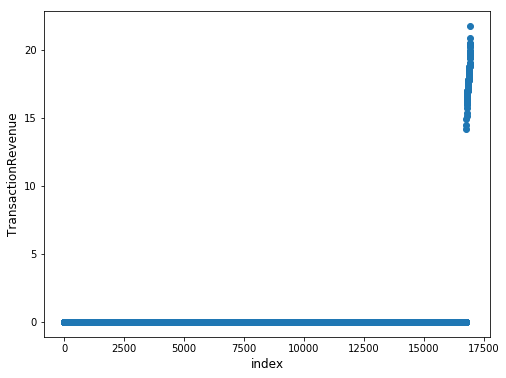

In [52]:
datavis["totals.transactionRevenue"] = datavis["totals.transactionRevenue"].astype('float')
gdf = datavis.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

In [53]:
nzi = pd.notnull(datavis["totals.transactionRevenue"]).sum()
paying = (gdf["totals.transactionRevenue"]>0).sum()
print("There are",paying,"paying customers")
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
print("Percentage of customers that generate revenue is",round(paying*100 / gdf.shape[0],2),"%")

There are 152 paying customers
Percentage of customers that generate revenue is 0.9 %


In [54]:
def scatter_plot(cnt_srs, color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace
datavis['date'] = datavis['date'].apply(lambda x: dt.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
cnt_srs = datavis.groupby('date')['totals.transactionRevenue'].agg(['size', 'count'])
cnt_srs.columns = ["count", "count of non-zero revenue"]
cnt_srs = cnt_srs.sort_index()
cnt_srs.index = cnt_srs.index.astype('str')
trace1 = scatter_plot(cnt_srs["count"], 'red')
trace2 = scatter_plot(cnt_srs["count of non-zero revenue"], 'blue')

fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.08,
                          subplot_titles=["Date - Visitors", "Date - Paying Customers"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig['layout'].update(height=800, width=800, paper_bgcolor='rgb(233,233,233)', title="Date Plots")
init_notebook_mode(connected=True)
iplot(fig, filename='date-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]



In [55]:
def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

# Device Browser
cnt_srs = datavis.groupby('device.browser')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(149, 48, 90, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(149, 48, 90, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(149, 48, 90, 0.6)')

# Device Category
cnt_srs = datavis.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(28, 151, 89, 0.6)')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(28, 151, 89, 0.6)')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(28, 151, 89, 0.6)')

# Operating system
cnt_srs = datavis.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(60, 150, 60, 0.6)')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10),'rgba(60, 150, 60, 0.6)')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10),'rgba(60, 150, 60, 0.6)')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Device Browser - Visitors", "Device Browser - Paying Customers", "Device Browser - Mean Revenue",
                                          "Device Category - Visitors",  "Device Category - Paying Customers", "Device Category - Mean Revenue", 
                                          "Device OS - Visitors", "Device OS - Paying Customers", "Device OS - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Device Plots")
init_notebook_mode(connected=True)
iplot(fig, filename='device-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



In [56]:
# Continent
cnt_srs = datavis.groupby('geoNetwork.continent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(78, 50, 120, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(78, 50, 120, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(78, 50, 120, 0.6)')

# Sub-continent
cnt_srs = datavis.groupby('geoNetwork.subContinent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'black')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'black')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'black')

# Network domain
cnt_srs = datavis.groupby('geoNetwork.networkDomain')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'orange')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'orange')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Continent - Visitors", "Continent - Paying Customers", "Continent - Mean Revenue",
                                          "Sub Continent - Visitors",  "Sub Continent - Paying Customers", "Sub Continent - Mean Revenue",
                                          "Network Domain - Visitors", "Network Domain - Paying Customers", "Network Domain - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1500, width=1200, paper_bgcolor='rgb(233,233,233)', title="Geography Plots")
init_notebook_mode(connected=True)
iplot(fig, filename='geo-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



In [57]:
cnt_srs = datavis.groupby('totals.pageviews')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(60), 'gray')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'gray')
trace5 = horizontal_bar_chart(cnt_srs["mean"].head(60), 'gray')

# Hits
cnt_srs = datavis.groupby('totals.hits')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", 'mean']
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace3 = horizontal_bar_chart(cnt_srs["count"].head(60), 'blue')
trace4 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'blue')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(60), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Total Pageviews - Visitors", "Total Pageviews - Paying Customers", "Total Pageviews - Mean Revenue",
                                          "Total Hits - Visitors",  "Total Hits - Paying Customers", "Total Hits - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace5, 1, 3)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Visitor Profile Plots")
init_notebook_mode(connected=True)
iplot(fig, filename='visitor-profile-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



In [58]:
cnt_srs = datavis.groupby('trafficSource.source')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'orange')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'orange')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'orange')

# Sub-continent
cnt_srs = datavis.groupby('trafficSource.medium')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'green')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'green')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'green')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Traffic Source - Visitors", "Traffic Source - Paying Customers", "Traffic Source - Mean Revenue",
                                          "Traffic Source Medium - Visitors",  "Traffic Source Medium - Paying Customers", "Traffic Source Medium - Mean Revenue"
                                          ])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1000, width=1200, paper_bgcolor='rgb(233,233,233)', title="Traffic Source Plots")
init_notebook_mode(connected=True)
iplot(fig, filename='traffic-source-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



In [59]:
cnt_srs = datavis.groupby('totals.sessionQualityDim')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(60), 'cyan')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'cyan')
trace5 = horizontal_bar_chart(cnt_srs["mean"].head(60), 'cyan')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Session Quality - Visitors", "Session Quality - Paying Customers", "Session Quality - Mean Revenue",
                                          "Time On Site - Visitors",  "Time On Site - Paying Customers", "Time On Site - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace5, 1, 3)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Visitor Profile Plots")
init_notebook_mode(connected=True)
iplot(fig, filename='visitor-profile-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



<a id="2.4"></a>
### Feature Engineering

The feature engineering function accomplishes numerous tasks necessary prior to the machine learning models. First, when analyzing the dataframe, it was determined that there were multiple features that were similar to the target feature totals.transactionRevenue such as totals.totalTransactionRevenue and totals.transactions. Including these in our analysis would likely have skewed the final results of the model as they contain very similar values to the target. Therefore, these features were removed. Other features deemed to possess no analytical value such as the visitID and hits were removed. Included in this category are features that have over 95% missing values such as trafficSource.adwordsClickInfo.adNetworkType. Values could have been imputed for the missing values in this columns, but when over 95% of the values in the column are missing it likely would not have yielded ideal results. 

Other columns with missing values were left unaddressed, as both of the models being employed in this problem are able to deal with missing values with strong in-built methods. Next, the categoric features were encoded, and the numeric columns were converted to float values. Additionally, missing values for the target totals.transactionRevenue were imputed with zero. This is reasonable, as missing values in these columns likely indicates that no transaction took place. Lastly, the date feature was converted into a standard date format.  

In [60]:
def featureEngineering(df):
    'Function requires a dataframe as an input, and will output a feature Engineered dataframe'
    #Calculate number of constant columns that can be dropped
    columns_constant = [i for i in df.columns if df[i].nunique(dropna=False)==1 ]
    # Drop features that are very similar to our target feature or will have no analytical value
    similarToFeature = ['totals.totalTransactionRevenue'] + ['totals.transactions']
    noAnalyticalValue =  ['visitId']+['customDimensions']+['hits']+['trafficSource.adwordsClickInfo.adNetworkType']+['trafficSource.adwordsClickInfo.isVideoAd']+['trafficSource.adwordsClickInfo.page']+['trafficSource.adwordsClickInfo.slot']
    tot = similarToFeature + noAnalyticalValue
    if 'totals.totalTransactionRevenue' and 'totals.transactions' and 'visitId' and 'fullVisitorId' and 'customDimensions' and 'hits' and 'trafficSource.adwordsClickInfo.adNetworkType' and 'trafficSource.adwordsClickInfo.isVideoAd'and 'trafficSource.adwordsClickInfo.page' and 'trafficSource.adwordsClickInfo.slot'in df.columns:
        columns_drop = columns_constant + tot
        #Drop constant columns 
        df= df.drop(columns_drop, axis=1)
    else:
        df= df.drop(columns_constant, axis=1)
        
    #Encode the categoric features to numeric 
    categoric_features = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect', 'device.isMobile']
    for i in categoric_features:
        if i in df.columns:
            encode = sklearn.preprocessing.LabelEncoder()
            encode.fit(df[i].values.astype('str'))
            df[i] = encode.transform(list(df[i].values.astype('str')))
    
    #Convert numeric features to float values
    numeric_features = ["totals.hits", "totals.pageviews",'totals.transactionRevenue',"visitNumber", "visitStartTime", 'totals.bounces',  'totals.newVisits','totals.sessionQualityDim', 'totals.timeOnSite']
    for i in numeric_features:
        df[i] = df[i].astype(float)
    
    #Encode Zeroes for nan values in totals.bounces & totals.transactionRevenues
    df['totals.transactionRevenue'].fillna(0,inplace=True)
    
    #Convert date to datetime
    df['date'] = pd.to_datetime(df['date'], format = "%Y%m%d")
    return df

In [61]:
#FeatureEngineer training and testing data 
trainingData = featureEngineering(trainingData)
testingData = featureEngineering(testingData)

In [62]:
#Attempted Reading in Batches
# Function runs and produces an output but not as intended 
# def dataPipeline(filename):
#     'dataPipeline is a function that takes a csv as an input, and returns a fully pre-processed Pandas dataframe ready for'
#     'ML Algorithms'
#     #Start Time of Function
#     start_time = dt.datetime.now()
#     print("Started at ", start_time)
#     # Read number of file lines in the dataset
#     num_lines = int(sum(1 for line in open(filename))) 
#     # Process in chunk sizes of 1%
#     batchSize = int(0.01*num_lines)
#     # Initialize a List to hold all of the processed, chunked dataframes
#     result = []
#     #For Parser
#     JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
#     print('Entering into processing the csv file by batches')
#     for batch in pd.read_csv(filename, chunksize=batchSize,
#                      converters={column: json.loads for column in JSON_COLUMNS}, 
#                      dtype={'fullVisitorId': 'str'}):
#         parsed = Parser(batch)
#         processed = featureEngineering(parsed)
#         result.append(processed)
#     Output = pd.concat(result)
#     #Time it took for function to finish
#     end_time = dt.datetime.now()
#     elapsed_time = end_time - start_time
#     print ("Preprocessed ", filename, "completely. Elapsed time: ", elapsed_time)
#     return Output

In [63]:
print(trainingData.shape)
trainingData.head()

(17083, 31)


,channelGrouping,date,fullVisitorId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.gclId,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,1,2017-10-16,4447569759370230345,1.0,1.508203e+09,5,1,1,1,391,2,153,66,1587,251,12,NaN,4.0,1.0,4.0,1.0,66.0,0.0,25,745,3,0,94,0,466,0
1,3,2017-10-16,8449727979333841797,1.0,1.508193e+09,5,0,0,6,342,2,153,59,0,43,12,NaN,6.0,1.0,6.0,2.0,40.0,0.0,25,745,3,1,3,4,466,18
2,0,2017-10-16,0258560966793548223,1.0,1.508164e+09,9,0,0,15,391,4,105,66,1101,251,21,NaN,7.0,1.0,7.0,1.0,243.0,0.0,25,745,10,1,94,1,466,1
3,3,2017-10-16,2120129608233101123,1.0,1.508177e+09,9,0,0,15,391,2,95,66,2131,251,3,NaN,8.0,1.0,8.0,1.0,111.0,0.0,25,745,3,1,57,4,466,8
4,3,2017-10-16,3848523864758719206,1.0,1.508189e+09,5,0,0,3,391,2,153,66,0,251,12,NaN,9.0,1.0,7.0,6.0,250.0,0.0,25,745,3,1,3,4,466,18


In [64]:
print(testingData.shape)
testingData.head()

(4015, 31)


,channelGrouping,date,fullVisitorId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.gclId,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,5,2018-05-11,5299820794845174508,2.0,1.526088e+09,1,0,0,3,92,2,105,38,0,138,10,NaN,5.0,NaN,3.0,1.0,28.0,0.0,0,107,1,1,31,0,1,0
1,5,2018-05-11,3326540121689239742,1.0,1.526068e+09,1,0,0,3,9,2,105,11,0,76,10,NaN,5.0,1.0,4.0,1.0,42.0,0.0,0,107,1,1,31,0,1,0
2,3,2018-05-11,0121413971533176085,1.0,1.526098e+09,10,1,1,8,67,2,105,37,175,24,10,NaN,6.0,1.0,4.0,1.0,60.0,0.0,0,107,1,1,1,4,0,12
3,3,2018-05-11,8816603995507550690,2.0,1.526078e+09,1,0,0,2,164,2,105,37,0,24,10,NaN,6.0,NaN,5.0,8.0,258.0,0.0,0,107,1,0,31,4,0,12
4,1,2018-05-11,6216204101074901430,1.0,1.526050e+09,1,0,0,4,164,2,105,37,0,24,10,NaN,14.0,1.0,12.0,52.0,387.0,0.0,0,107,1,0,2,0,0,0


<a id="3"></a>
## Building 2 Baseline Models

The two baseline models chosen to be used for this regression task were the LGBM and the XGB models. The XGB model was chosen as it has proven to consistently perform well on machine learning challenges on Kaggle. The LGBM is a newer model that is less proven, but is stated to run multiple times faster than the XGB and achieve the same accuracies. The two models will be compared in this section. 

<a id="3.1"></a>
### Seperate Features, Target, and Construct Validation Set

The first step taken in building the two models was the separation of the training set into a training and validation set based on an 80/20 split on the dat feature in the training set between the two. This split between the training and validation set is a typical sized split that should help prevent overtraining of the models being built. Afterwards, the three datasets were split into their respective targets and features. 

In [65]:
#Split training set for validation set 
train_df = trainingData[trainingData['date']> dt.date(2016,11,30)]
validation_df = trainingData[trainingData['date']<=dt.date(2016,11,30)]

features = [] 
label = []
for i in trainingData.columns:
    if i != 'totals.transactionRevenue' and i!='date' and i!= 'fullVisitorId' and i!= 'visitStartTime':
        features.append(i)
    elif i == 'totals.transactionRevenue':
        label.append(i)
#Target
train_y = np.log1p(train_df[label])
validation_y = np.log1p(validation_df[label])
test_y = np.log1p(testingData[label])
#Features
train_x = train_df[features]
validation_x = validation_df[features]
test_x = testingData[features]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning:

Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning:

Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.



In [66]:
print('training dataframe shape:' , train_df.shape)
print('validation dataframe shape:' , validation_df.shape)
print('training features shape:' , train_x.shape)
print('validation features shape:' , validation_x.shape)
print('training label shape:' , train_y.shape)
print('validation label shape:' , validation_y.shape)
print('testing features shape:' , test_x.shape)
print('testing label shape:' , test_y.shape)

training dataframe shape: (13617, 31)
validation dataframe shape: (3466, 31)
training features shape: (13617, 27)
validation features shape: (3466, 27)
training label shape: (13617, 1)
validation label shape: (3466, 1)
testing features shape: (4015, 27)
testing label shape: (4015, 1)


<a id="3.2"></a>

### LGBM

#### Hyperparameter Tuning LGBM

The first step completed in constructing the LGBM model was hyperparameter tuning conducted using the the training set with the RandomizedSearchCV. The RandomizedSearchCV was used for hyperparameter tuning because it produces reasonable results in a very flexible and efficient manner. During hyperparameter tuning, this model ran extremely fast, being able to fit 3 cross validation folds with 100 iterations totalling 300 possible fits of hyperparameters. An important note here is that since early stopping is being used to optimize the number of estimators, one of the most important parameters in the model, n_estimators was set to an upper maximum bound. The final hyperparameters, other than n_estimators, can be found in the output below. The final tuned parameters were saved and can be seen in the dictionary "SavedLGBMParams" in the interest of efficiency.

In [67]:
# Prior to early stopping, determine best hyperparameters for most important parameters in 
#LGBM models. n_estimators, one of the most important parameters, is determined by 
# early stopping, so a maximum limit is set here 
params_LGB ={'num_leaves': sp_randint(6, 50), 
             "learning_rate": sp_uniform(0.05, 0.4),
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6)}

LGBReg = lgb.LGBMRegressor(n_estimators=1500, random_state=40, silent = True, n_jobs=4,max_depth =-1)
LGBHP_opt = RandomizedSearchCV(
    estimator=LGBReg, param_distributions=params_LGB, 
    n_iter=100,
    cv=3,scoring='neg_mean_squared_error',random_state=40, refit=True, verbose=True)

In [69]:
LGBHP_opt.fit(train_x,train_y)

In [ ]:
FinalLGBParams = LGBHP_opt.best_params_
AdditionalParams = {'objective': 'regression', 'metric':'rmse', 'verbosity':-1}
for i in AdditionalParams:
    FinalLGBParams[i] = AdditionalParams[i]
FinalLGBParams

In [71]:
#Save the Optimum LGB Params to increase efficiency of not having to run each time to obtain them
SavedLGBParams = {'colsample_bytree': 0.8539721005885168,
 'learning_rate': 0.05722266438555726,
 'min_child_samples': 453,
 'min_child_weight': 1,
 'num_leaves': 35,
 'subsample': 0.6218338710274947,
 'objective': 'regression',
 'metric': 'rmse',
 'verbosity': -1}

#### Function to Run LGBM

The function defined to build the LGBM is shown below. This function utilizes early stopping to optimize the n_estimators in the model utilizing the training set and the validation set. This is an important step, as early stopping will help mitigate any overfitting issues that could arise when building this model. After the model was built, predictions were obtained using the optimum model as determined by early stopping. These predictions were returned in the function output, along with the model. 

In [72]:
#Define function to use Early Stopping LightGBM model with parameters determined from RandomizedSearchCV
def LGBM(train_x, train_y, val_x, val_y, test_x, test_y, LGBParams):
    lgbtrain = lgb.Dataset(train_x, label=train_y)
    lgbval = lgb.Dataset(val_x, val_y)
    
    start_time = time.time()
    model = lgb.train(LGBParams, lgbtrain, 1000, valid_sets = [lgbval], early_stopping_rounds=100, verbose_eval=100)
    end_time = time.time()
    print(end_time-start_time)
    
    predictions_test= model.predict(test_x, num_iteration = model.best_iteration)
    predictions_validation = model.predict(val_x, num_iteration= model.best_iteration)
    
    return predictions_test, predictions_validation, model

In [73]:
# Run LGBM
predictions_test, predictions_validation, modellgb = LGBM(train_x, train_y, validation_x, validation_y, test_x, test_y,SavedLGBParams)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.6309
[200]	valid_0's rmse: 1.62188
[300]	valid_0's rmse: 1.61746
[400]	valid_0's rmse: 1.61275
[500]	valid_0's rmse: 1.61083
[600]	valid_0's rmse: 1.60963
[700]	valid_0's rmse: 1.60826
[800]	valid_0's rmse: 1.60685
[900]	valid_0's rmse: 1.60489
[1000]	valid_0's rmse: 1.60581
Did not meet early stopping. Best iteration is:
[950]	valid_0's rmse: 1.60442
4.241919040679932


#### Evaluation Metrics LGBM

Relevant regression evaluation metrics were then obtained for the model for both the validation data set and testing data set. In summary, the performance of the model is slightly worse on the testing dataset for all metrics considered. This indicates that the model doesn't have any major issues generalizing, and overfitting has been mostly avoided. 

In [74]:
#Testing Set
MSE_LGB_test = sklearn.metrics.mean_squared_error(test_y,predictions_test)
MAE_LGB_test= sklearn.metrics.mean_absolute_error(test_y, predictions_test)
RMSE_LGB_test = np.sqrt(MSE_LGB_test)
#Validation Set
MSE_LGB_val = sklearn.metrics.mean_squared_error(validation_y, predictions_validation)
MAE_LGB_val = sklearn.metrics.mean_absolute_error(validation_y, predictions_validation)
RMSE_LGB_val = np.sqrt(MSE_LGB_val)
print('Mean square Error for the LGBM testing set: {}, Mean absolute error for the LGBM testing set: {}, Root mean square error for the LGBM testing set: {}'.format(MSE_LGB_test, MAE_LGB_test, RMSE_LGB_test))

print('Mean square Error for the LGBM validation set: {}, Mean absolute error for the LGBM validation set: {}, Root mean square error for the LGBM validation set: {}'.format(MSE_LGB_val, MAE_LGB_val, RMSE_LGB_val))

Mean square Error for the LGBM testing set: 3.4084601891915356, Mean absolute error for the LGBM testing set: 0.4847850944275474, Root mean square error for the LGBM testing set: 1.8462015570331252
Mean square Error for the LGBM validation set: 2.5741667765353267, Mean absolute error for the LGBM validation set: 0.39738552506235636, Root mean square error for the LGBM validation set: 1.6044210097525295


#### Feature Importance LGBM

Lastly, feature importances were obtained for the LGBM. The top 3 features as determined by the LGBM are totals.timeOnSite, geoNetwork.networkDomain, and totals.sessionQualityDim. This results seem to be reasonably intuitive after the exploratory analysis that was conducted on the dataset.

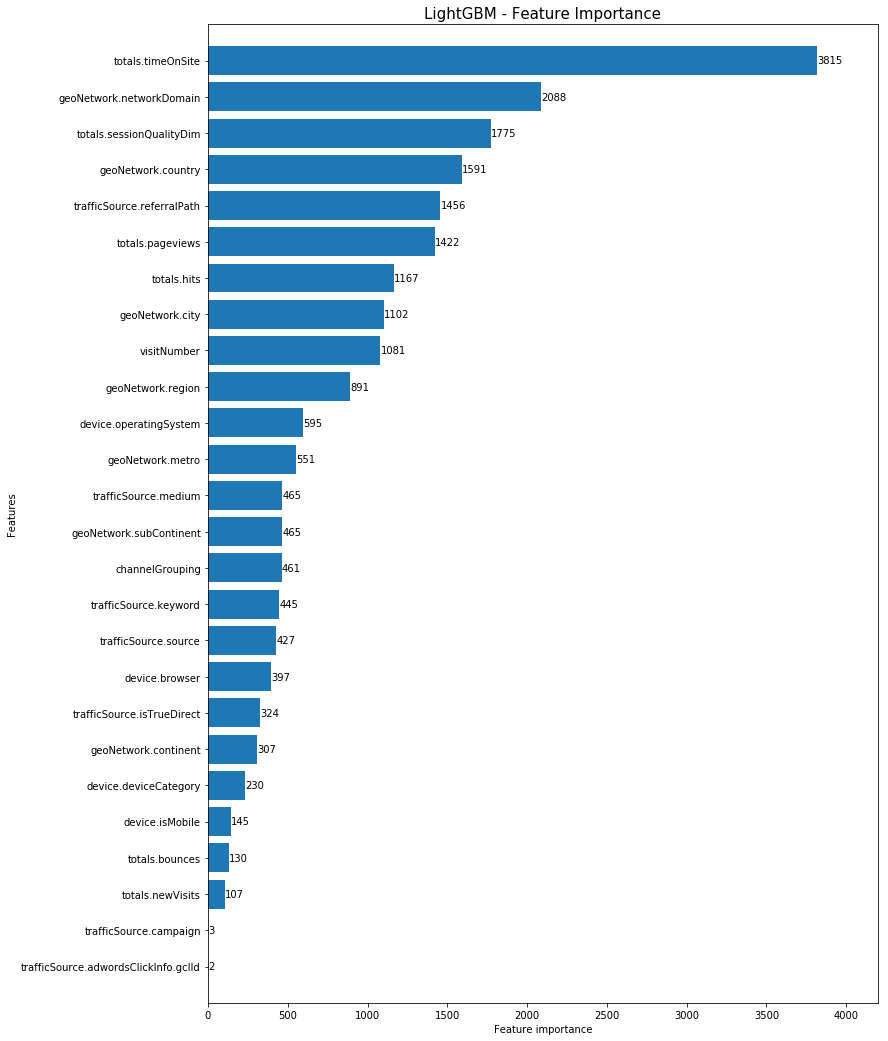

In [75]:
#Obtain and plot figure importance for the LGBM
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(modellgb, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

<a id="3.3"></a>
### XGBoost

#### Hyperparameter Tuning XGBoost

Similar to the LGBM, the first step completed for the XGBoost model was hyperparameter tuning with the RandomizedSearchCV. To reiterate what was previously stated, this method allows for very flexible and efficient hyperparameter tuning compared to other methods. As early stopping was again going to be used with the training and validation datasets to determine the n_estimators, the value was set to a high bound of 2500 here. The difference between the two models really showed in this step, as originally 3 cross validation folds with 100 iterations each was used here similar to the LGBM. This took way to long a time to execute. Instead, the cross validation folds was reduced to 2 with 50 iterations in each fold. This solution still took much longer to execute than the LGBM's hyperparameter tuning, at a run time of approximately 29 minutes. The tuned hyperparameters for the XGBoost model were saved in a dictionary called "SavedXGBParams" in the interest of efficiency, and can be seen there.

In [76]:
# Prior to early stopping, determine best hyperparameters for most important parameters in 
#XGB model. n_estimators, one of the most important parameters, is determined by 
# early stopping, so a maximum limit is set here 
params_XGB= {  
    "learning_rate": sp_uniform(0.05, 0.4),
    "colsample_bytree": sp_uniform(loc=0.4, scale=0.6),
    'max_depth': sp_randint(3, 40),
    "subsample": sp_uniform(loc=0.2, scale=0.8),
    "gamma": sp_uniform(0, 10),
    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    "min_child_weight": [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
}

XGBReg = xgb.XGBRegressor(n_estimators=2500, random_state=40, silent = True, n_jobs=4)
XGBHP_opt = RandomizedSearchCV(
    estimator=XGBReg, param_distributions=params_XGB, 
    n_iter=50,cv=2,scoring='neg_mean_squared_error',random_state=40, refit=True, verbose=True)


In [ ]:
XGBHP_opt.fit(train_x,train_y)

In [ ]:
FinalXGBParams = XGBHP_opt.best_params_
FinalXGBParams

In [ ]:
AdditionalParams = {'objective': 'reg:linear', 'eval_metric':'rmse', 'silent':True, 'random_state':40}
for i in AdditionalParams:
    FinalXGBParams[i] = AdditionalParams[i]
FinalXGBParams

In [77]:
#Save the Optimum XGB Params to increase efficiency of not having to run each time to obtain them
SavedXGBParams = {'colsample_bytree': 0.5454951393008803,
 'gamma': 4.834820481469037,
 'learning_rate': 0.050158252068833425,
 'max_depth': 36,
 'min_child_weight': 1,
 'reg_alpha': 100,
 'subsample': 0.9278827742521691,
 'objective': 'reg:linear',
 'eval_metric': 'rmse',
 'silent': True,
 'random_state': 40}
SavedXGBParams

{'colsample_bytree': 0.5454951393008803,
 'gamma': 4.834820481469037,
 'learning_rate': 0.050158252068833425,
 'max_depth': 36,
 'min_child_weight': 1,
 'reg_alpha': 100,
 'subsample': 0.9278827742521691,
 'objective': 'reg:linear',
 'eval_metric': 'rmse',
 'silent': True,
 'random_state': 40}

#### Function to Run XGBoost

The below function was used to run the XGBoost model on the dataset. This function utilizes early stopping with the training and validation dataset to find the optimum number of n_estimators to avoid overfitting problems. After the model is built with early stopping, predictions are obtained using the validation set and testing dataset. The function returns the final model and the predictions on both of the datasets. 

In [78]:
#Define function to run XGBoost model
def XGB(train_x, train_y, val_x, val_y, test_x, test_y, paramsXGB):    
    xgb_train_dataMatrix = xgb.DMatrix(train_x, label = train_y)
    xgb_val_dataMatrix = xgb.DMatrix(val_x, label = val_y)
    xgb_test_dataMatrix = xgb.DMatrix(test_x, label= test_y)
    
    start_time = time.time()
    model = xgb.train(paramsXGB, xgb_train_dataMatrix, 
                      num_boost_round=2000, 
                      evals= [(xgb_train_dataMatrix, 'train'), (xgb_val_dataMatrix, 'valid')],
                      early_stopping_rounds=100, 
                      verbose_eval=100
                     )    
    end_time = time.time()
    print(end_time-start_time)
    
    y_pred_val = model.predict(xgb_val_dataMatrix, ntree_limit=model.best_ntree_limit)
    y_pred_test = model.predict(xgb_test_dataMatrix, ntree_limit=model.best_ntree_limit)
    return y_pred_test, y_pred_val, model

In [79]:
#Run XGBM
predictions_testingData, predictions_validationData, model = XGB(train_x, train_y, validation_x, validation_y, test_x, test_y,SavedXGBParams)

[0]	train-rmse:1.66014	valid-rmse:1.7989
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[100]	train-rmse:1.24918	valid-rmse:1.61975
Stopping. Best iteration:
[59]	train-rmse:1.29716	valid-rmse:1.61678

1.7584304809570312


#### Evaluation Metrics XGBoost generated on the Testing Set

Relevant regression evaluation metrics were obtained on both the validation and testing dataset. Similar to the LGBM, the model performs slightly worse on the testing set compared to the validation set. This indicates that the XGBoost model does not have major issues generalizing, and overfitting has been mostly avoided. The models will be compared in the section titled "Summary and Comparison of the Two Models". 

In [80]:
#Testing Set
MSE_XGB_testing = sklearn.metrics.mean_squared_error(test_y,predictions_testingData)
MAE_XGB_testing= sklearn.metrics.mean_absolute_error(test_y, predictions_testingData)
RMSE_XGB_testing = np.sqrt(MSE_XGB_testing)

#Validation Set
MSE_XGB_validation = sklearn.metrics.mean_squared_error(validation_y, predictions_validationData)
MAE_XGB_validation = sklearn.metrics.mean_absolute_error(validation_y, predictions_validationData)
RMSE_XGB_validation = np.sqrt(MSE_XGB_validation)
print('Mean square Error for the XGB testing set: {}, Mean absolute error for the XGB testing set: {}, Root mean square error for the XGB testing set: {}'.format(MSE_XGB_testing, MAE_XGB_testing, RMSE_XGB_testing))

print('Mean square Error for the XGB validation set: {}, Mean absolute error for the XGB validation set: {}, Root mean square error for the XGB validation set: {}'.format(MSE_XGB_validation, MAE_XGB_validation, RMSE_XGB_validation))

Mean square Error for the XGB testing set: 3.650399237216839, Mean absolute error for the XGB testing set: 0.35364854115773003, Root mean square error for the XGB testing set: 1.910601799752329
Mean square Error for the XGB validation set: 2.6139863567086423, Mean absolute error for the XGB validation set: 0.340946571971888, Root mean square error for the XGB validation set: 1.6167827178407872


#### Feature Importance XGBoost

The feature importances as reported by the XGBoost model are shown in the figure below. The XGBoost reports that total.sessionQualityDim, totals.hits, and totals.timeOnSite are the three most important features for this prediction. These results also seem to be fairly intuitive after the exploratory analysis. 

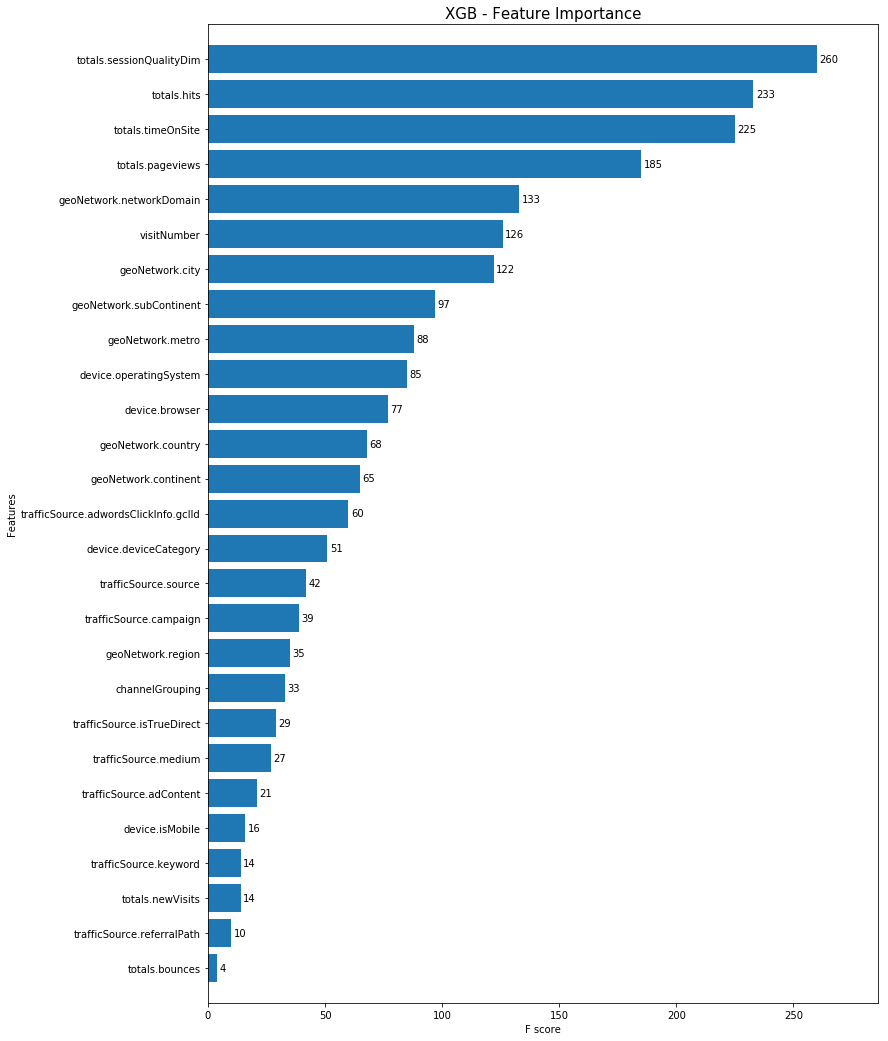

In [81]:
#Obtain and plot figure importance for the LGBM
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("XGB - Feature Importance", fontsize=15)
plt.show()

<a id="3.4"></a>
### Summary and Comparison of the Two Models

Firstly, the LightGBM showcased a much faster training time than the XGBoost model. This is best exemplified through the hyperparameter tuning that took place, as the LightGBM model was able to fit 3 cross validation folds with 100 possible combinations in each fold in approximately 8 minutes, while the XGBoost model fit 2 cross validation folds with 50 possible combinations in each fold in approximately 29 minutes. Next, the LightGBM model had slightly better accuracy on MSE and RMSE on both the validation set and test set, while performing slightly worse in terms of MAE on both datasets. Overall, it is clear the LightGBM model is the superior model on this dataset when considering the evaluation metrics with the time taken to build and run the models. It is also important to note that neither the lightGBM and XGBoost models seemed to generalize significantly better than the other, as both of the models prediction accuracy decreased around the same values from the validation set to the testing set. An interesting point of comparison between the models is that during early stopping, the LGBM model produced an optimum value of 950 estimators, while the XGBoost model produced an optimum value of 59 estimators.

In terms of feature importance, the models seem to have some agreement on the top 5 most important features for this regression task, as totals.sessionQualityDim, totals.timeOnSite, and geoNetwork.networkDomain recieved scores in the top 5 for both models feature importances. This consensus indicates these three features are crucial attributes in determining revenue per customer. 